In [70]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer 
import nltk
import re

In [32]:
stop_words = nltk.corpus.stopwords.words('english')
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def clean_tweet(tweet):
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet.lower())
    tweet = re.sub('[\s]+', ' ', tweet)  
    tweet = re.sub(r'\W*\b\w{1,3}\b', '', tweet)
    tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet) 
    return tweet
    tweet_token_list = [word for word in tweet.split(' ')if word not in my_stopwords] # remove stopwords
    tweet_token_list = [PorterStemmer().stem(tweet) if '#' not in word else word for word in tweet_token_list] # apply word rooter
    tweet = ' '.join(tweet_token_list)
    return tweet

In [33]:
cdf = pd.read_csv('cdf.csv')

In [34]:
cdf['PM'].value_counts()

none             275161
Boris Johnson     16408
Theresa May       13735
Name: PM, dtype: int64

In [26]:
#reducing dataset from 300k to 50k (removing 90% of the none values)
#cdf = cdf.drop(cdf[cdf['PM'] == 'none'].sample(frac=.93).index)

In [36]:
df = cdf.drop(cdf[(cdf.PM == 'none')].index)

In [37]:
df['TEXT_CLEANED'] = df.TEXT.apply(clean_tweet)

### Checking optimal number of clusters

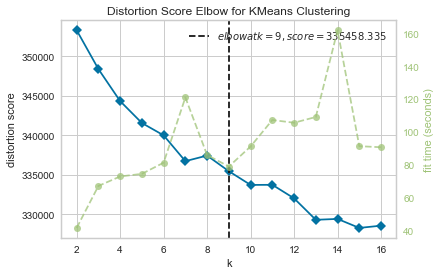

In [41]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,17))
visualizer.fit(count_m)
visualizer.poof()

### Vectorizing with CountVectorizer

In [42]:
#vectorizing with CountVectorizer
c_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
c_vect.fit(df["TEXT_CLEANED"])
count_m = c_vect.transform(df["TEXT_CLEANED"])

In [48]:
#implementing kmeans
km = KMeans(n_clusters = 3, n_init = 10, n_jobs = -1)
km.fit(count_m)
c_clusters = km.labels_.tolist()

In [ ]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(3):
    print("Cluster {}: Words:".format(i))
    for ind in order_centroids[i, :10]: 
        print('    %s' % feature_names[ind])

In [53]:
df['c_labels'] = c_clusters

### Vectorizing with TfidfVectorizer

In [44]:
#vectorizing with TfidfVectorizer
tweets = [tweet for tweet in df["TEXT_CLEANED"]]
tfidf_vec = TfidfVectorizer(use_idf=True, ngram_range=(1,3))  
tfidf_m = tfidf_vec.fit_transform(tweets)  
feature_names = tfidf_vec.get_feature_names()  

In [61]:
#implementing kmeans 
km = KMeans(n_clusters = 3, n_init = 10, n_jobs = -1)
km.fit(tfidf_m)
t_clusters = km.labels_.tolist()

In [63]:
df['t_labels'] = t_clusters

In [62]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(3):
    print("Cluster {}: Words:".format(i))
    for ind in order_centroids[i, :10]: 
        print('    %s' % feature_names[ind])

Cluster 0: Words:
    brexit
    theresa
    boris
    deal
    that
    with
    will
    this
    have
    johnson
Cluster 1: Words:
    will your name
    brexit will your
    will your
    your name
    signed
    name
    brexit will
    jeremycorbyn prevent trade
    may jeremycorbyn prevent
    jeremycorbyn prevent
Cluster 2: Words:
    boris johnson
    johnson
    boris
    brexit
    deal
    johnson brexit
    boris johnson brexit
    deal brexit
    plan
    says


### Checking results

In [67]:
df['c_labels'].value_counts()

1    13342
0    12455
2     4346
Name: c_labels, dtype: int64

In [68]:
df['t_labels'].value_counts()

0    26162
2     3737
1      244
Name: t_labels, dtype: int64

In [77]:
df.dtypes

MONTH_INT           int64
MONTH_STR          object
USERNAME           object
TEXT               object
TWEET_PROCESSED    object
TWEET_CLEANED      object
PM                 object
TEXT_CLEANED       object
c_labels            int64
t_labels            int64
dtype: object

In [82]:
df.dropna(inplace=True)

In [91]:
df.isna().sum()

MONTH_INT          0
MONTH_STR          0
USERNAME           0
TEXT               0
TWEET_PROCESSED    0
TWEET_CLEANED      0
PM                 0
TEXT_CLEANED       0
c_labels           0
t_labels           0
SENTIMENT_CP       0
SENTIMENT_NEUT     0
SENTIMENT_NEG      0
SENTIMENT_POS      0
SENTIMENT          0
SENTIMENT_N        0
dtype: int64

In [86]:
sid = SentimentIntensityAnalyzer()

df['SENTIMENT_CP'] = df['TEXT_CLEANED'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['SENTIMENT_NEUT'] = df['TEXT_CLEANED'].apply(lambda x: sid.polarity_scores(x)['neu'])
df['SENTIMENT_NEG'] = df['TEXT_CLEANED'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['SENTIMENT_POS'] = df['TEXT_CLEANED'].apply(lambda x:sid.polarity_scores(x)['pos'])

df.loc[df.SENTIMENT_CP > 0,'SENTIMENT'] = 'positive'
df.loc[df.SENTIMENT_CP == 0,'SENTIMENT'] = 'neutral'
df.loc[df.SENTIMENT_CP < 0,'SENTIMENT'] = 'negative'

In [87]:
df['SENTIMENT_N'] = df['SENTIMENT'].apply(lambda x: 2 if x == 'positive' else (0 if x == 'negative' else 1))